
# Cepheids

Cepheids are a type of variable star that pulsate radially, varying in both diameter and temperature, which produces changes in brightness with a well-defined stable period and amplitude. These stars are significant in the field of astronomy for several reasons:

1. **Standard Candles**: Cepheids have a well-established relationship between their luminosity and pulsation period, known as the Leavitt law or period-luminosity relation. This makes them excellent standard candles for measuring astronomical distances.

2. **Distance Measurement**: By observing the period of a Cepheid's brightness variations, astronomers can determine its absolute magnitude. Comparing this with the apparent magnitude allows for the calculation of the distance to the star, which is crucial for mapping the scale of the universe.

3. **Galactic and Extragalactic Studies**: Cepheids are used to measure distances within our galaxy and to nearby galaxies. This helps in understanding the structure and scale of the Milky Way and the local group of galaxies.

4. **Historical Importance**: The discovery of Cepheids in the Andromeda galaxy by Edwin Hubble was pivotal in establishing that the universe is expanding, leading to the formulation of the Big Bang theory.

Cepheids continue to be a vital tool in modern astrophysics, aiding in the calibration of other distance measurement methods and contributing to our understanding of the cosmos.

# Part 1

The data in ```cepheids.csv``` is organised in two columns: the period of the cepheid variable and its absolute magnitude calculated from mean luminosity.

These two values are actually related by the Leavitt law:
$$M = a \cdot \log_{10}{P} + b$$

First, find the constants $a$ and $b$ in this relation to fit the given data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

file_path= 'cepheids.csv'
cepheids_data= pd.read_csv(file_path)

period= cepheids_data['Period']
magnitude= cepheids_data['M']
log_period= np.log10(period)
slope, intercept, r_value, p_value, std_err= linregress(log_period, magnitude)
a, b = slope, intercept

print(f"Constants for Leavitt Law:\n a = {a:.4f}, b = {b:.4f}")


Constants for Leavitt Law:
 a = -2.2164, b = -1.6809


Next, plot the data along with your fitted line to visually verify that you have found the correct constants.

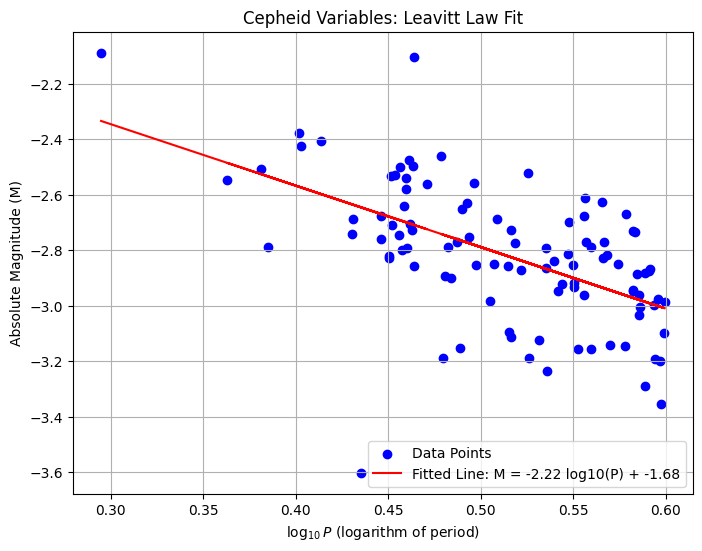

In [2]:
fitted_magnitude= a*log_period+b

plt.figure(figsize=(8, 6))
plt.scatter(log_period, magnitude, label="Data Points", color="blue")
plt.plot(log_period, fitted_magnitude, label=f"Fitted Line: M = {a:.2f} log10(P) + {b:.2f}", color="red")
plt.xlabel(r"$\log_{10}{P}$ (logarithm of period)")
plt.ylabel("Absolute Magnitude (M)")
plt.title("Cepheid Variables: Leavitt Law Fit")
plt.legend()
plt.grid(True)
plt.show()


# Part 2

Now we are ready to use the result we have obtained from the above markdown to solve the problem.

Given in the ```curves.csv``` file is the data of the light curves of many cepheids in the line of sight of a galaxy. The data contains three columns: ID(Unique for every cepheid), JD (the julian date of observation) and the apparent magnitude observed.

First we need to find the period of each cepheid.

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

cepheids_df= pd.read_csv('cepheids.csv')
curves_df= pd.read_csv('curves.csv')

def find_period(jd_values, mag_values):
    peaks, _= find_peaks(-mag_values)
    if len(peaks) < 2:
        return np.nan
    periods= np.diff(jd_values[peaks])
    return np.mean(periods)

grouped_curves= curves_df.groupby("ID") #Group by ID to calculate periods for each cepheid
periods= {}
for cepheid_id, group in grouped_curves:
    jd_sorted= group.sort_values("JD")
    periods[cepheid_id]= find_period(jd_sorted["JD"].values, jd_sorted["m"].values)

periods_df= pd.DataFrame(list(periods.items()), columns=["ID", "Period"])
periods_df.dropna(inplace=True)

print("Calculated Periods:")
print(periods_df)


Calculated Periods:
          ID     Period
0      60103  13.423331
1      98001  11.884222
2      99586  15.615355
3     100187  11.412897
4     100256  18.466645
..       ...        ...
970  3293951  18.173773
971  3302966   4.297999
972  3303225  11.394799
973  3309725   6.624160
974  3315129  40.787900

[975 rows x 2 columns]


Next, using the calculated periods, find the absolute magnitude of these stars using the relation you found earlier.



In [4]:
a = -2.2164
b = -1.6809
periods_df["M"]= a*np.log10(periods_df["Period"])+b #Calculation of absolute magnitudes

print("\nCalculated Absolute Magnitudes:")
print(periods_df)



Calculated Absolute Magnitudes:
          ID     Period         M
0      60103  13.423331 -4.180690
1      98001  11.884222 -4.063465
2      99586  15.615355 -4.326288
3     100187  11.412897 -4.024512
4     100256  18.466645 -4.487722
..       ...        ...       ...
970  3293951  18.173773 -4.472334
971  3302966   4.297999 -3.084471
972  3303225  11.394799 -4.022985
973  3309725   6.624160 -3.500854
974  3315129  40.787900 -5.250482

[975 rows x 3 columns]


Then, using the apparent magnitude data, find the distance to these cepheid variables.

In [5]:
merged_df= curves_df.merge(periods_df, on="ID") #Merge data to include absolute magnitudes
merged_df["Distance_pc"]= 10**((merged_df["m"]-merged_df["M"]+5)/5) #Using the distance modulus formula
distance_df= merged_df.groupby("ID")["Distance_pc"].mean().reset_index()
distance_df.rename(columns={"Distance_pc": "Average_Distance_pc"}, inplace=True)

print("\nCalculated Distances to Cepheids:")
print(distance_df)



Calculated Distances to Cepheids:
          ID  Average_Distance_pc
0      60103         5.448410e+05
1      98001         1.259229e+06
2      99586         9.295605e+05
3     100187         8.771771e+05
4     100256         8.690345e+05
..       ...                  ...
970  3293951         1.876721e+06
971  3302966         8.089107e+05
972  3303225         1.492322e+06
973  3309725         1.466430e+04
974  3315129         1.186482e+06

[975 rows x 2 columns]


Finally, find the distance to the galaxy being observed.

In [8]:
galaxy_distance_pc= distance_df["Average_Distance_pc"].mean()
print(f"\nDistance to the galaxy: {galaxy_distance_pc:.2f} parsecs")
final_results_df= periods_df.merge(distance_df, on="ID")
final_results_df.rename(columns={"Average_Distance_pc": "Cepheid_Distance_pc"}, inplace=True)

final_results_df= pd.concat([
    final_results_df,
    pd.DataFrame([{"ID": "Galaxy", "Period": None, "M": None, "Cepheid_Distance_pc": galaxy_distance_pc}])
], ignore_index=True)

final_results_df.to_csv("final_results.csv", index=False) #Save to a single CSV file
print("All results saved to 'final_results.csv'")



Distance to the galaxy: 1071475.81 parsecs
All results saved to 'final_results.csv'


<ipython-input-8-d86ecff34fb4>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results_df = pd.concat([


# Part 3

Cepheid variable stars are known for their periodic changes in luminosity due to their pulsations. These stars exhibit a well-defined relationship between their pulsation period and intrinsic luminosity, known as the period-luminosity relation. However, the mechanism driving these pulsations involves complex interactions between radiation pressure, gas pressure, and opacity within the star's interior.

(a) Give a qualitative explanation of the thermal instability that leads to the pulsations in Cepheid variable stars, focusing on the role of the κ-mechanism (opacity mechanism).

The pulsations of Cepheid variable stars are driven by a thermal instability mechanism known as the {$\kappa$-mechanism} (opacity mechanism). This process involves a feedback loop where changes in the opacity of the star's material play a crucial role.

When a layer within the star compresses, its temperature and density increase. In regions where partially ionized gases (such as helium) dominate, the ionization of atoms becomes more efficient, leading to an increase in opacity, $\kappa$. This increased opacity traps heat and radiation, causing the layer to absorb more energy. As a result, the layer becomes over-pressurized and begins to expand.

During the expansion phase, the temperature and density of the layer decrease. This reversal reduces the efficiency of ionization, causing a drop in opacity, $\kappa$. The reduced opacity allows radiation to escape more freely, leading to a loss of energy. Consequently, the layer cools and contracts, restarting the cycle.

This repeating cycle of compression and expansion, driven by changes in opacity, sustains the pulsations observed in Cepheid stars. The specific conditions for this mechanism are met in zones within the star where partially ionized elements are abundant, such as the helium ionization zone in the stellar envelope.

The periodic pulsations generated by this mechanism are closely related to the star's intrinsic properties, giving rise to the well-known period-luminosity relationship. This makes Cepheid variable stars essential tools for determining cosmic distances.
